# Cross-Entropy Method

---

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### 2. Instantiate the Environment and Agent

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]


/home/jingbo/anaconda3/envs/rlearning/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### 3. Train the Agent with the Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

Episode 10	Average Score: -1.44
Episode 20	Average Score: -3.98
Episode 30	Average Score: -4.18
Episode 40	Average Score: 2.57
Episode 50	Average Score: 18.74
Episode 60	Average Score: 29.35
Episode 70	Average Score: 38.69
Episode 80	Average Score: 45.65
Episode 90	Average Score: 47.98
Episode 100	Average Score: 52.56
Episode 110	Average Score: 62.09
Episode 120	Average Score: 72.28
Episode 130	Average Score: 82.21
Episode 140	Average Score: 89.48

Environment solved in 47 iterations!	Average Score: 90.83


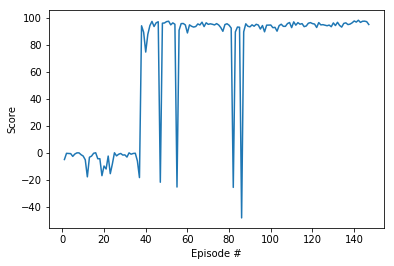

In [3]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [11]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
reward_sum = 0
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
#     env.render()
    next_state, reward, done, _ = env.step(action)
#     print("state:", state)
#     print("action:", action)
    print("rewards:", reward)
    reward_sum += reward
    state = next_state
    if done:
        break
print(reward_sum)
env.close()

rewards: -0.02423797464671793
rewards: -0.025573127640940642
rewards: -0.026872751219606528
rewards: -0.0281221842251572
rewards: -0.029307357603329722
rewards: -0.030414971071201082
rewards: -0.031432600640393105
rewards: -0.032348886158832
rewards: -0.03315356890389012
rewards: -0.033837568418393006
rewards: -0.03439301515032298
rewards: -0.034813267488858914
rewards: -0.03509296558564188
rewards: -0.03522799118943709
rewards: -0.03521554657290018
rewards: -0.03505418541615235
rewards: -0.03474382348142626
rewards: -0.03428583440801027
rewards: -0.03368306618090742
rewards: -0.03293989577742309
rewards: -0.03206228918624312
rewards: -0.031057814282400287
rewards: -0.029935579012823156
rewards: -0.028706284058388577
rewards: -0.02738204245767726
rewards: -0.025976279933183834
rewards: -0.024503571489842193
rewards: -0.022979405203958338
rewards: -0.02141987601858233
rewards: -0.019841442558431146
rewards: -0.0182605925782263
rewards: -0.016693494177530965
rewards: -0.01515568248600383

## QC for the other test weights

In [6]:
# load the weights from file
device = torch.device("cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""
    ## Input states, output actions 

    def __init__(self, state_size, action_size, seed, output_activation=None, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.output_activation = output_activation
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))
    
    def __call__(self, state):
        return self.forward(state)

state_size = 2
action_size = 1
actor = Actor(state_size=state_size, action_size=action_size, seed=42, fc_units=10)
weights = "../p2_continuous-control/models/actor_MountainCarContinuous-v0_episodes_2000_score_-0.107997777870349062019_06_08_02_14_53_ddpg_n_explore_m_t4_checkpoint.pth"
actor.load_state_dict(torch.load(weights))


state = env.reset()
reward_sum = 0
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = actor(state)
#     env.render()
    print("state:", state)
    print("action:", action)
    next_state, reward, done, _ = env.step(action)
    reward_sum += reward
    state = next_state
    if done:
        break
print(reward_sum)
env.close()

state: tensor([-0.4488,  0.0000])
action: tensor([0.0337])
state: tensor([-0.4493, -0.0005])
action: tensor([0.0341])
state: tensor([-0.4503, -0.0010])
action: tensor([0.0346])
state: tensor([-0.4518, -0.0015])
action: tensor([0.0350])
state: tensor([-0.4538, -0.0020])
action: tensor([0.0355])
state: tensor([-0.4562, -0.0024])
action: tensor([0.0360])
state: tensor([-0.4591, -0.0029])
action: tensor([0.0366])
state: tensor([-0.4624, -0.0033])
action: tensor([0.0371])
state: tensor([-0.4662, -0.0037])
action: tensor([0.0377])
state: tensor([-0.4703, -0.0041])
action: tensor([0.0383])
state: tensor([-0.4747, -0.0044])
action: tensor([0.0388])
state: tensor([-0.4794, -0.0047])
action: tensor([0.0394])
state: tensor([-0.4845, -0.0050])
action: tensor([0.0399])
state: tensor([-0.4897, -0.0052])
action: tensor([0.0405])
state: tensor([-0.4951, -0.0054])
action: tensor([0.0410])
state: tensor([-0.5007, -0.0056])
action: tensor([0.0415])
state: tensor([-0.5064, -0.0057])
action: tensor([0.0420

state: tensor([-0.5706, -0.0020])
action: tensor([0.0439])
state: tensor([-0.5722, -0.0016])
action: tensor([0.0437])
state: tensor([-0.5733, -0.0011])
action: tensor([0.0435])
state: tensor([-0.5740, -0.0007])
action: tensor([0.0432])
state: tensor([-5.7428e-01, -2.5182e-04])
action: tensor([0.0429])
state: tensor([-5.7409e-01,  1.9123e-04])
action: tensor([0.0426])
state: tensor([-0.5735,  0.0006])
action: tensor([0.0422])
state: tensor([-0.5724,  0.0011])
action: tensor([0.0418])
state: tensor([-0.5709,  0.0015])
action: tensor([0.0414])
state: tensor([-0.5690,  0.0019])
action: tensor([0.0410])
state: tensor([-0.5667,  0.0023])
action: tensor([0.0405])
state: tensor([-0.5640,  0.0027])
action: tensor([0.0400])
state: tensor([-0.5609,  0.0031])
action: tensor([0.0396])
state: tensor([-0.5575,  0.0034])
action: tensor([0.0391])
state: tensor([-0.5538,  0.0037])
action: tensor([0.0386])
state: tensor([-0.5498,  0.0040])
action: tensor([0.0381])
state: tensor([-0.5456,  0.0042])
action

state: tensor([-0.4961, -0.0040])
action: tensor([0.0400])
state: tensor([-0.5002, -0.0041])
action: tensor([0.0404])
state: tensor([-0.5045, -0.0042])
action: tensor([0.0408])
state: tensor([-0.5088, -0.0043])
action: tensor([0.0412])
state: tensor([-0.5132, -0.0044])
action: tensor([0.0415])
state: tensor([-0.5176, -0.0044])
action: tensor([0.0419])
state: tensor([-0.5220, -0.0044])
action: tensor([0.0422])
state: tensor([-0.5263, -0.0043])
action: tensor([0.0424])
state: tensor([-0.5305, -0.0042])
action: tensor([0.0427])
state: tensor([-0.5346, -0.0041])
action: tensor([0.0429])
state: tensor([-0.5386, -0.0040])
action: tensor([0.0431])
state: tensor([-0.5424, -0.0038])
action: tensor([0.0432])
state: tensor([-0.5460, -0.0036])
action: tensor([0.0433])
state: tensor([-0.5494, -0.0034])
action: tensor([0.0434])
state: tensor([-0.5525, -0.0031])
action: tensor([0.0434])
state: tensor([-0.5553, -0.0028])
action: tensor([0.0434])
state: tensor([-0.5578, -0.0025])
action: tensor([0.0434

state: tensor([-0.4906,  0.0032])
action: tensor([0.0344])
state: tensor([-0.4876,  0.0030])
action: tensor([0.0343])
state: tensor([-0.4848,  0.0028])
action: tensor([0.0343])
state: tensor([-0.4823,  0.0025])
action: tensor([0.0343])
state: tensor([-0.4800,  0.0023])
action: tensor([0.0343])
state: tensor([-0.4780,  0.0020])
action: tensor([0.0344])
state: tensor([-0.4763,  0.0017])
action: tensor([0.0345])
state: tensor([-0.4749,  0.0014])
action: tensor([0.0346])
state: tensor([-0.4738,  0.0011])
action: tensor([0.0347])
state: tensor([-0.4730,  0.0008])
action: tensor([0.0349])
state: tensor([-4.7256e-01,  4.5216e-04])
action: tensor([0.0351])
state: tensor([-4.7244e-01,  1.2352e-04])
action: tensor([0.0353])
state: tensor([-4.7264e-01, -2.0569e-04])
action: tensor([0.0356])
state: tensor([-0.4732, -0.0005])
action: tensor([0.0359])
state: tensor([-0.4740, -0.0009])
action: tensor([0.0362])
state: tensor([-0.4752, -0.0012])
action: tensor([0.0365])
state: tensor([-0.4767, -0.0015]

action: tensor([0.0357])
state: tensor([-0.5091,  0.0035])
action: tensor([0.0355])
state: tensor([-0.5057,  0.0034])
action: tensor([0.0353])
state: tensor([-0.5023,  0.0034])
action: tensor([0.0351])
state: tensor([-0.4990,  0.0033])
action: tensor([0.0350])
state: tensor([-0.4959,  0.0031])
action: tensor([0.0348])
state: tensor([-0.4929,  0.0030])
action: tensor([0.0347])
state: tensor([-0.4901,  0.0028])
action: tensor([0.0347])
state: tensor([-0.4876,  0.0026])
action: tensor([0.0346])
state: tensor([-0.4852,  0.0024])
action: tensor([0.0346])
state: tensor([-0.4830,  0.0021])
action: tensor([0.0346])
state: tensor([-0.4812,  0.0019])
action: tensor([0.0347])
state: tensor([-0.4795,  0.0016])
action: tensor([0.0347])
state: tensor([-0.4782,  0.0013])
action: tensor([0.0349])
state: tensor([-0.4771,  0.0011])
action: tensor([0.0350])
state: tensor([-0.4764,  0.0008])
action: tensor([0.0351])
state: tensor([-4.7590e-01,  4.6300e-04])
action: tensor([0.0353])
state: tensor([-4.7574e